<a href="https://colab.research.google.com/github/abhijeet3922/Change-Detection-in-Satellite-Imagery/blob/master/3_develop_vision_rag_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **End-to-End Visual Augmented Q&A Process: Vision-RAG**

This notebook combines the first two example notebooks to develop end-to-end process of Vision-RAG. This is a two step process:
- **Retrieval step**: Using Visual LM embedding (ColPali) to get best matching pages.
- **Generation step**: Multi-modal LLM (Qwen) utilizes the retrieved pages, augments the prompt, and generates a final answer.

Following are the code components for this notebook:
1. [Installing Libraries & Imports](#)
2. [Loading Visual Language Model (VLM): ColPali](#)
3. [Ingest PDF Data as Embeddings](#)
4. [Scoring: Retrieve Best Match with Query](#)
5. [Load Multi-modal LLM: Qwen2.5-VL 3B](#)
6. [Prepare Prompt with Retrieved Page](#)
7. [Generate Answer: Model Inference](#)



### 1. Install Libraries & Imports

In [1]:
!pip install colpali-engine==0.3.2
!pip install pdf2image
!sudo apt-get install poppler-utils
!pip install qwen-vl-utils==0.0.08

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from torch.utils.data import DataLoader
from qwen_vl_utils import process_vision_info
from colpali_engine.models import ColPali, ColPaliProcessor
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

### 2. Loading Visual Language Model (VLM): ColPali

In [3]:
model_name = "vidore/colpali-v1.3"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### 3. Ingest PDF Data as Embeddings

In [4]:
images = convert_from_path('/content/google-alphabet-2024.pdf')
print("Number of pages:", len(images))

Number of pages: 46


In [5]:
dataloader = DataLoader(images,
                        batch_size=1,
                        shuffle=False,
                        collate_fn=lambda x: processor.process_images(x).to(model.device))

In [6]:
dataset = []
for batch in tqdm(dataloader):
  with torch.no_grad():
    batch = {k: v.to(model.device) for k,v in batch.items()}
    embeddings = model(**batch)
  dataset.extend(list(torch.unbind(embeddings.to("cpu").to(torch.float32))))

100%|██████████| 46/46 [02:10<00:00,  2.85s/it]


In [7]:
query = ["What is the revenue from Google Cloud for 2023 and 2024 ?"]

batch_queries = processor.process_queries(query).to(model.device)
with torch.no_grad():
  query_embeddings = model(**batch_queries)

### 4. Scoring: Retrieve Best Match with Query

The **score_multi_vector** function is used to evaluate the similarity between multiple query vectors and document embeddings. It works by comparing different parts of a query with corresponding sections of a document, assigning a relevance score based on their match.

How It Works ?
1. <i>Breaks Down the Query</i> - Splits the query into multiple vectors.
2. <i>Matches Against Document Patches</i> - Each query vector is compared with different sections (patches) of the document.
3. <i>Computes Similarity Scores</i> - Calculates how well each query vector aligns with document patches using dot product similarity.
4. <i>Aggregates the Scores</i> - The final score is a sum of individual matches to rank documents.

This method ensures fine-grained retrieval also called <i>Late-Interation</i>, making it useful for visual document search where both text and layout matter

In [8]:
def score(query_embedding, dataset):
  scores = processor.score_multi_vector(query_embedding, dataset)
  scores = np.array(scores)
  matched_pages = scores.flatten().argsort()[::-1]
  return scores, matched_pages

In [9]:
scores, matched_pages = score(list(torch.unbind(query_embeddings.to("cpu").to(torch.float32))),dataset)
scores, matched_pages

(array([[11.867018 , 14.762573 , 13.16333  , 15.581064 , 12.713327 ,
         16.089264 , 14.579987 , 15.919231 , 15.612173 , 18.811823 ,
         21.61379  , 14.380378 , 13.1756935, 14.715182 , 14.155935 ,
         13.291354 , 14.263426 , 16.072008 , 15.416011 , 16.333286 ,
         15.256524 , 23.022377 , 16.689919 , 17.05439  , 15.524802 ,
         15.306576 , 21.610111 , 23.187355 , 20.287514 , 19.550488 ,
         15.976536 , 19.732815 , 21.978022 , 22.830036 , 17.511196 ,
         18.56966  , 22.568735 , 15.682828 , 20.53175  , 16.355246 ,
         16.809597 , 14.227849 , 16.379839 , 15.669473 , 11.879147 ,
         13.36992  ]], dtype=float32),
 array([27, 21, 33, 36, 32, 10, 26, 38, 28, 31, 29,  9, 35, 34, 23, 40, 22,
        42, 39, 19,  5, 17, 30,  7, 37, 43,  8,  3, 24, 18, 25, 20,  1, 13,
         6, 11, 16, 41, 14, 45, 15, 12,  2,  4, 44,  0]))

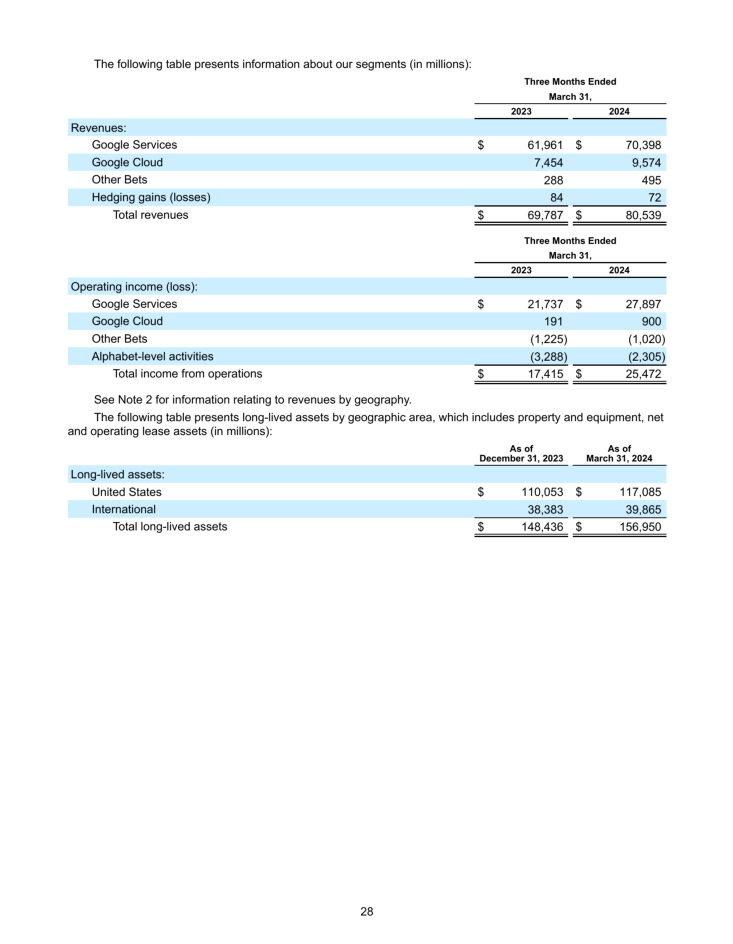

In [10]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(images[matched_pages[0]])
ax.axis("off")
plt.show()

### 5. Load Multi-modal LLM: Qwen2.5-VL 3B

In [11]:
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)


# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### 6. Prepare Prompt with Retrieved Page

In [12]:
messages = [

    {"role": "user",
     "content": [
         {"type": "image",
          "image": images[matched_pages[0]],
          "resized_height": 1024,
          "resized_width": 1024,
         },
        {"type": "text", "text": "What is the revenue from Google Cloud for 2023 and 2024 ?"}]},

]

In [13]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

### 7. Generate Answer: Model Inference

In [14]:
# Inference: Generation of the output

with torch.no_grad():
  generated_ids = model.generate(**inputs, max_new_tokens=64)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The revenue from Google Cloud for 2023 was $7,454 million, and for 2024 it was $9,574 million.']
